
# This notebook was modified to work in Colab.
---



## Downloads

Install cartopy module

In [30]:
!apt-get -qq install python-cartopy python3-cartopy
import cartopy

Selecting previously unselected package python-pkg-resources.
(Reading database ... 145674 files and directories currently installed.)
Preparing to unpack .../0-python-pkg-resources_39.0.1-2_all.deb ...
Unpacking python-pkg-resources (39.0.1-2) ...
Selecting previously unselected package python-pyshp.
Preparing to unpack .../1-python-pyshp_1.2.12+ds-1_all.deb ...
Unpacking python-pyshp (1.2.12+ds-1) ...
Selecting previously unselected package python-shapely.
Preparing to unpack .../2-python-shapely_1.6.4-1_amd64.deb ...
Unpacking python-shapely (1.6.4-1) ...
Selecting previously unselected package python-six.
Preparing to unpack .../3-python-six_1.11.0-2_all.deb ...
Unpacking python-six (1.11.0-2) ...
Selecting previously unselected package python-cartopy:amd64.
Preparing to unpack .../4-python-cartopy_0.14.2+dfsg1-2build3_amd64.deb ...
Unpacking python-cartopy:amd64 (0.14.2+dfsg1-2build3) ...
Selecting previously unselected package python3-pkg-resources.
Preparing to unpack .../5-pyth

Clone the Github Repo:

In [8]:
!git clone https://github.com/silburt/DeepMoon.git
%cd DeepMoon/
!mkdir zenodo_downloads
!ls

Cloning into 'DeepMoon'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 774 (delta 2), reused 0 (delta 0), pack-reused 768
Receiving objects: 100% (774/774), 23.18 MiB | 35.80 MiB/s, done.
Resolving deltas: 100% (492/492), done.
/content/DeepMoon
catalogues	       model_train.py		  run_model_train.py
docs		       README.md		  tests
get_unique_craters.py  requirements.txt		  utils
input_data_gen.py      run_get_unique_craters.py  zenodo_downloads
LICENSE.md	       run_input_data_gen.py


Download the dataset and other required files:

In [18]:
# 274.4 MB
!wget -P ./zenodo_downloads/ https://zenodo.org/record/1133969/files/LunarLROLrocKaguya_118mperpix.png

# 123.4 MB
!wget -P ./zenodo_downloads/ https://zenodo.org/record/1133969/files/model_keras2.h5

# 9.9 GB
!wget -P ./zenodo_downloads/ https://zenodo.org/record/1133969/files/train_images.hdf5 

# 261.7 MB
!wget -P ./zenodo_downloads/ https://zenodo.org/record/1133969/files/train_craters.hdf5

# 375.9 KB
!wget -P ./zenodo_downloads/ https://zenodo.org/record/1133969/files/post-processed_test_craters.npy

--2020-01-28 12:56:36--  https://zenodo.org/record/1133969/files/LunarLROLrocKaguya_118mperpix.png
Resolving zenodo.org (zenodo.org)... 188.184.95.95
Connecting to zenodo.org (zenodo.org)|188.184.95.95|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 274371452 (262M) [image/png]
Saving to: ‘./zenodo_downloads/LunarLROLrocKaguya_118mperpix.png’

LunarLROLrocKaguya_ 100%[===================>] 261.66M  21.8MB/s    in 13s     

2020-01-28 12:56:50 (20.4 MB/s) - ‘./zenodo_downloads/LunarLROLrocKaguya_118mperpix.png’ saved [274371452/274371452]

--2020-01-28 12:56:51--  https://zenodo.org/record/1133969/files/model_keras2.h5
Resolving zenodo.org (zenodo.org)... 188.184.95.95
Connecting to zenodo.org (zenodo.org)|188.184.95.95|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 123444040 (118M) [application/octet-stream]
Saving to: ‘./zenodo_downloads/model_keras2.h5’

model_keras2.h5     100%[===================>] 117.72M  19.4MB/s    in 6.5s   



---


# Introduction

This notebook demonstrates how to use some elements of the DeepMoon repo with the [Zenodo dataset](https://doi.org/10.5281/zenodo.1133969) associated with the repo.  Running the notebook requires a subset of the DeepMoon dependencies, as well as the [Matplotlib](https://matplotlib.org/) package.

In [0]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import os
from PIL import Image    # Requires Pillow
Image.MAX_IMAGE_PIXELS = None

This is the filepath to the downloaded Zenodo dataset, and needs to be modified to point to your download location:

In [0]:
zenodo_path = '/content/DeepMoon/zenodo_downloads'
deepmoon_path = '/content/DeepMoon'

# HDF5 Datasets

## Image Datasets

The training, validation and testing DEM images and target masks used to train and evaluate the DeepMoon model are found in `train_images.hdf5`, `dev_images.hdf5` and `test_images.hdf5`, respectively.  Also included in the files are each image's longitude/latitude bounds, which are used to post-process DeepMoon's crater detections.

These data can be read in using `h5py`.  Let's read in the `train_images.hdf5` data:

In [0]:
train_imgs = h5py.File(zenodo_path + '/train_images.hdf5', 'r')

Input images are 256 x 256 8-bit greyscale images, and target masks are 256 x 256 float arrays whose values fall between 0 and 1.  30000 inputs and targets are stored in the HDF5 file as two 30000 x 256 x 256 arrays; inputs can be found under the `'input_images'` entry, and targets under `'target_masks'`.  A target mask represents the ground truth crater locations of the input with the same image number (first array dimension).  Let's plot one input-target pair as an example (and set `vmin` and `vmax` to increase contrast of the input):

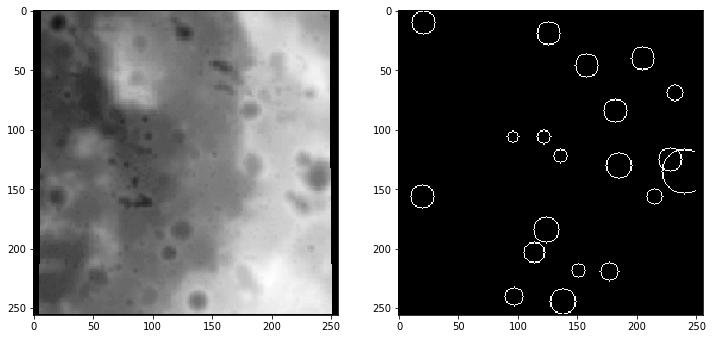

In [22]:
fig = plt.figure(figsize=[12, 6])
[ax1, ax2] = fig.subplots(1,2)
ax1.imshow(train_imgs['input_images'][3][...], origin='upper', cmap='Greys_r', vmin=120, vmax=200)
ax2.imshow(train_imgs['target_masks'][3][...], origin='upper', cmap='Greys_r')
plt.show()

The longitude and latitude bounds of the input image can be found under `'longlat_bounds'`.  Here, instead of a 30000-element array, long/lat bounds are indexed by `'img_xxxxx'`, where xxxxx is the (zero-padded) image number, so the 4th image's boundaries are:

In [23]:
train_imgs['longlat_bounds']['img_00003'][...]

array([-177.85546875, -173.87109375,   15.4453125 ,   19.4296875 ])

The definitions of these numbers is under the "definition" attribute for the entry:

In [24]:
train_imgs['longlat_bounds'].attrs['definition']

'(long min, long max, lat min, lat max) of the cropped image.'

Other entries in the HDF5 are to correct for image distortion during post-processing, or are unused in the current pipeline.  Each entry in the HDF5 has definition metadata under its `.attrs['definition']` attribute.

In [25]:
train_imgs['pix_bounds'].attrs['definition']

'Pixel bounds of the Global DEM region that was cropped for the image.'

In [26]:
train_imgs['target_masks'].attrs['definition']

'Target mask dataset.'

## Crater Tables

The ground truth crater data for the images is stored in Pandas HDFStore files `train_craters.hdf5`, `dev_craters.hdf5`, and `test_craters.hdf5` for the training, validation and testing data, respectively.  These tables are used for calculating accuracy metrics when tuning hyperparameters during training.  Let's read in the training ground truth:

In [0]:
ctrs = pd.HDFStore(zenodo_path + '/train_craters.hdf5', 'r')

Like the long/lat boundaries, crater dataframes are indexed by `'img_xxxxx'`, where xxxxx is the zero-padded image number for DEM images from `train_images.hdf5`.  The ground truth for image 3 is:

In [28]:
ctrs['img_00003']

,Diameter (km),Lat,Long,x,y,Diameter (pix)
0,10.550443,15.618482,-175.694082,138.439884,244.900215,22.300142
1,7.530385,15.693656,-176.356974,97.549874,240.048738,15.916739
2,7.943583,16.006064,-175.065360,177.137353,219.965795,16.790103
3,5.332220,16.036702,-175.482448,151.449356,218.081551,11.270547
4,8.098426,16.261849,-176.080687,114.628637,203.667608,17.117390
5,10.709987,16.564495,-175.923507,124.301628,184.276214,22.637364
6,9.185999,16.988845,-177.614291,20.729479,156.583553,19.416160
7,6.599598,16.994128,-174.429989,215.808468,156.407085,13.949364
8,18.446725,17.318118,-174.028395,240.208003,135.428068,38.990266
9,10.084412,17.403728,-174.914875,185.977665,130.334813,21.315106


Here, "Lat", "Long", and "Diameter (km)" are from the combined LROC-Head crater catalog, while "x", "y" and "Diameter (pix)" were derived from the former columns by the `input_data_gen.py` pipeline.

# Lunar DEM

`LunarLROLrocKaguya_118mperpix.png` is the [LRO LOLA and Kaguya Terrain Camera DEM Merge](https://astrogeology.usgs.gov/search/map/Moon/LRO/LOLA/Lunar_LRO_LrocKaguya_DEMmerge_60N60S_512ppd), downsampled to 118 m/pixel and 8 bits/pixel.  It is combined with the LROC-Head combined crater catalogue by the `input_data_gen.py` pipeline to create the type of image and ground truth crater datasets we worked with above.

We can create a (tiny) dataset by reading in the DEM and crater catalogues, then passing them the `GenDataset` function in `input_data_gen.py`.

In [31]:
# Load input_data_gen
import sys
sys.path.append(deepmoon_path)
import input_data_gen as igen
import utils.processing as proc

# Read source image.
img = Image.open(zenodo_path + "/LunarLROLrocKaguya_118mperpix.png").convert("L")
# Read and combine the LROC and Head datasets (stored under ../catalogues)
craters = igen.ReadLROCHeadCombinedCraterCSV(filelroc=deepmoon_path + "/catalogues/LROCCraters.csv",
                                             filehead=deepmoon_path + "/catalogues/HeadCraters.csv")

# Generate 100 image/target sets, and corresponding crater dataframes.  np.random.seed is set for consistency.
igen.GenDataset(img, craters, zenodo_path + '/test_zenodo', amt=25, seed=1337)

/content/DeepMoon/input_data_gen.py:96: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  copy=True)
/content/DeepMoon/input_data_gen.py:634: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  x, y = trf.coord2pix(craters["Long"].as_matrix(),
/content/DeepMoon/input_data_gen.py:635: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  craters["Lat"].as_matrix(),
/content/DeepMoon/input_data_gen.py:326: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  ilong = ctr_wrp["Long"].as_matrix()
/content/DeepMoon/input_data_gen.py:327: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  ilat = ctr_wrp["Lat"].as_matrix()
/co

This generates `test_zenodo_images.hdf5`, which stores DEM images, and `test_zenodo_craters.hdf5`, which stores ground truth crater data.  We read in the images and plot one pair:

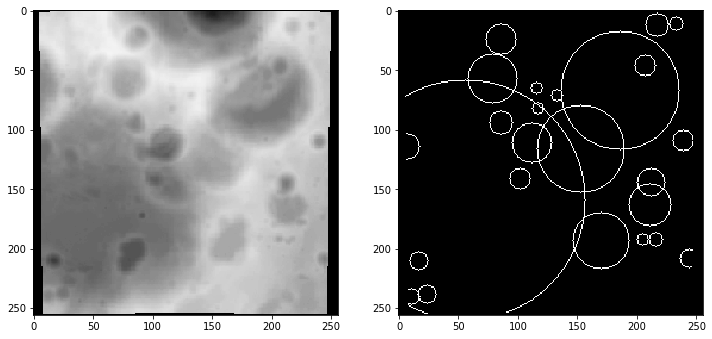

In [32]:
# Read in and pre-process data.
gen_imgs = h5py.File(zenodo_path + '/test_zenodo_images.hdf5', 'r')
sample_data = {'imgs': [gen_imgs['input_images'][...].astype('float32'),
                        gen_imgs['target_masks'][...].astype('float32')]}
proc.preprocess(sample_data)
sd_input_images = sample_data['imgs'][0]
sd_target_masks = sample_data['imgs'][1]

# Plot the data for fun.
fig = plt.figure(figsize=[12, 6])
[ax1, ax2] = fig.subplots(1,2)
ax1.imshow(sd_input_images[0].squeeze(), origin='upper', cmap='Greys_r', vmin=0, vmax=1.1)
ax2.imshow(sd_target_masks[0].squeeze(), origin='upper', cmap='Greys_r')
plt.show()

Arguments to `GenDataset` are listed in its docstring.  To easily run `GenDataset` and keep track of your input arguments, see the `run_input_data_gen.py` script in the repo.  This also uses `LunarLROLrocKaguya_118mperpix.png` (or any other DEM or global map); you'll have to specify its location.

# Generating Predictions From Trained Model Weights

`model_keras1.2.2.h5` and `model_keras2.h5` are respectively the Keras 1.2.2 and 2.0+ compatible model weights for the trained DeepMoon convolutional neural network (CNN).  These can be loaded into memory using Keras's `load_model` module.

To train a model from scratch, see `run_model_train.py`.

**Note:** DeepMoon was train using a 16GB Tesla P100 GPU, and so the model may use prohibitive amounts of memory on systems with less GPU or system RAM.

In [33]:
from keras.models import load_model
sys.path.append("%s/utils/"%deepmoon_path)
import template_match_target as tmt

# Load model
model = load_model(zenodo_path + '/model_keras2.h5')

Using TensorFlow backend.








Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:350: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


The model can then be used to predict target masks from input images, and extract crater rings from those predictions.  Let's try inserting image 17 from the generated data, and then plotting the predictions and extracted rings against the ground truth target mask.

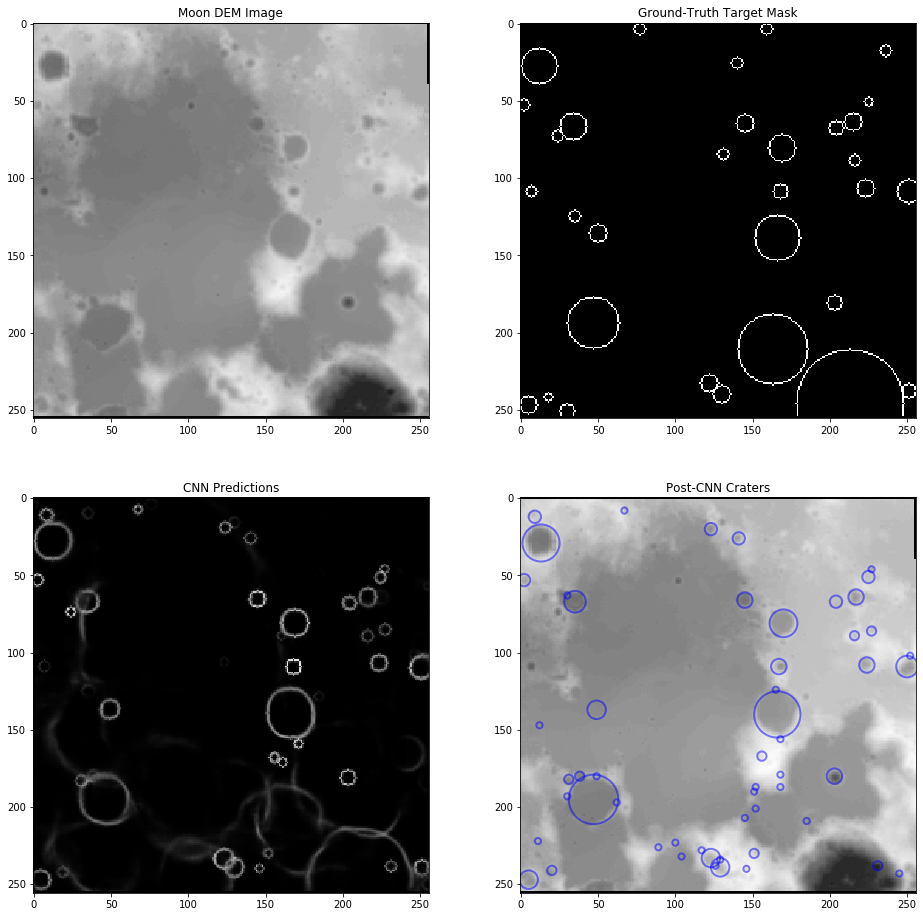

In [37]:
# Use the CNN to make a prediction.  We use [iwant:iwant + 1] to keep input as a 4D tensor.
# Input data MUST BE PREPROCESSED (see proc.preprocess, above) before being passed into model.predict
iwant = 11
pred = model.predict(sd_input_images[iwant:iwant + 1])
# Use scikit-image template matching to extract crater locations.  Only search for craters with r >= 3 pixels.
extracted_rings = tmt.template_match_t(pred[0].copy(), minrad=2.)

fig = plt.figure(figsize=[16, 16])
[[ax1, ax2], [ax3, ax4]] = fig.subplots(2, 2)
ax1.imshow(sd_input_images[iwant].squeeze(), origin='upper', cmap='Greys_r', vmin=0, vmax=1.1)
ax2.imshow(sd_target_masks[iwant].squeeze(), origin='upper', cmap='Greys_r')
ax3.imshow(pred[0], origin='upper', cmap='Greys_r', vmin=0, vmax=1)
ax4.imshow(sd_input_images[iwant].squeeze(), origin='upper', cmap="Greys_r")
for x, y, r in extracted_rings:
    circle = plt.Circle((x, y), r, color='blue', fill=False, linewidth=2, alpha=0.5)
    ax4.add_artist(circle)
ax1.set_title('Moon DEM Image')
ax2.set_title('Ground-Truth Target Mask')
ax3.set_title('CNN Predictions')
ax4.set_title('Post-CNN Craters')
plt.show()

As noted from the paper, the trained CNN effectively finds craters with radii $r < 15$ pixels, but has trouble with larger ones (we did not search for craters with radii $r < 3$ pixels).

# Post-Processed Craters

`post-processed_test_craters.npy` contains post-processed craters from the test set (`test_images.hdf5`) identified by our pipeline.  To make it, crater detections were aggregated from all test set DEM images, and their positions and sizes converted to longitude/latitude and kilometres.  The dataset was then filtered for duplicates.

Each crater entry is arranged as a tuple: (longitude, latitude, radii), where longitude and latitude are in degrees, and radius is in kilometres.

Here we visualize extracted craters directly onto a Lunar patch using the `crop_craters` function.

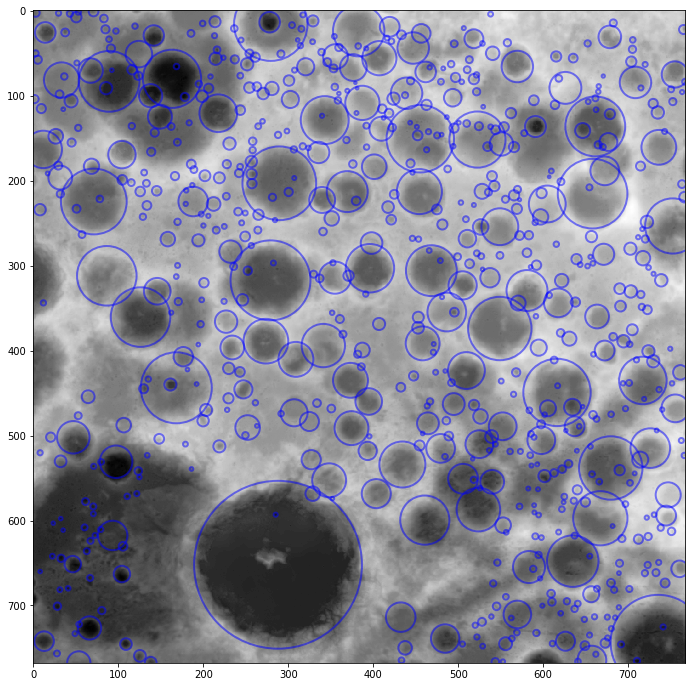

In [35]:
# Load coordinate transforms module from utils.
sys.path.append("%s/utils/"%deepmoon_path)
import transform as tfm

def crop_craters(craters, img_global, xp, yp, lenp):
    """Get desired cropped Lunar region"""
    xc = xp * img_global.size[0] / 3 + 2 * img_global.size[0] / 3
    yc = yp * img_global.size[1]
    rawlen = lenp * img_global.size[0] / 3
    
    box = np.array([xc, yc, xc + rawlen, yc + rawlen], dtype='float32')
    img_crop = img_global.crop(box)
    
    # Crop craters within bounding box, convert to pixel coordinates
    llbd = tfm.pix2coord(box[0::2], box[1::2], [-180., 180., -60., 60.], img_global.size)
    llbd = np.concatenate([llbd[0], llbd[1][::-1]])
    cLo, cLa, cR = craters[(craters.T[0] >= llbd[0]) & (craters.T[0] < llbd[1]) &
                           (craters.T[1] >= llbd[2]) & (craters.T[1] < llbd[3])].T
    x, y = tfm.coord2pix(cLo, cLa, llbd, img_crop.size)
    r = cR / ((llbd[3] - llbd[2]) * (np.pi / 180.0) * (1737.4 / (box[2] - box[0])))
    
    return np.asanyarray(img_crop), np.array(list(zip(x, y, r)))

# Load post-processed craters
craters = np.load(zenodo_path + '/post-processed_test_craters.npy')

# Dimensions of crop
longp = 0.5     # longitude coordinate as a percentage of Lunar test region (0-1 range)
latp = 0.5      # latitude coordinate as a percentage of Lunar test region (0-1 range)
lenp = 0.2      # length of cropped Lunar test region as a percentage  (0-1 range)

# Get cropped image of the Moon and corresponding cropped crater catalogue.
img_lowres = img.resize((int(img.size[0] / 8), int(img.size[1] / 8)))
img_crop, craters_crop = crop_craters(craters, img_lowres, longp, latp, lenp)

# Plot the cropped image alongside the cropped crater catalogue.
f, (ax1) = plt.subplots(1, 1, figsize=[12, 12])
ax1.imshow(img_crop, cmap='Greys_r', vmin=np.min(img_crop), vmax=np.max(img_crop))
for x, y, r in craters_crop:
    circle = plt.Circle((x, y), r, color='blue', fill=False, linewidth=2, alpha=0.5)
    ax1.add_artist(circle)
plt.show()